In [63]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from pixelator import read_pna as read
from pixelator.pna.plot import molecule_rank_plot

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
import pandas as pd
from pixelator.common.statistics import clr_transformation, dsb_normalize
import scanpy as sc
from pixelator.mpx.plot import density_scatter_plot
import scanpy.external as sce
import networkx as nx

from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
from sklearn.neighbors import NearestNeighbors
from scipy.stats import norm
from pixelator.common.statistics import clr_transformation, dsb_normalize

from pixelator.pna.analysis import calculate_differential_proximity
from rich import print
import anndata as ad
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
from statsmodels.stats.multitest import multipletests

import sys
sys.path.append('/home/projects/nyosef/zvise/PixelGen/PixelGen')

from multimodalvi import MultiModalSCVI
from multimodalvae import MultiModalVAE, AggMethod, D
from enums import AggMethod, D
from metrics import MultiModalVIMetrics
from sklearn.preprocessing import PowerTransformer
from pxl_utils import train_model, get_model_latents, convert_polarization_to_feature_matrix, \
     convert_colocalization_to_feature_matrix, download_pxl
from scvi_utils import plot_losses, pca_neighbors_umap, calc_PCA, add_one_hot_encoding_obsm, plot_cumulative_variance
from common_utils import standardize, std_clip, filter_hv, split_pair_column, filter_df_by_two_columns, rank_plot
from metrics import MultiModalVIMetrics, distr_autocorrelation_in_latent
from multimodalvi import MultiModalSCVI
from multimodalvae import MultiModalVAE, AggMethod, D
from enums import AggMethod, D
from scvi.model import SCVI


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
DATA_DIR=Path('/home/projects/nyosef/zvise/PixelGen/PixelGen/Data/')
files = [f for f in DATA_DIR.rglob('*.pxl') if f.is_file()]
data = read(files)
adata=data.adata()
adata.obs['condition'] = adata.obs['sample'].apply(lambda x: 'PHA' if 'PHA' in x else ('unstim' if 'unstim' in x else None))
adata = adata[adata.obs["tau_type"] == "normal"].copy()


In [49]:
adata.obs.condition.value_counts()

condition
unstim    1078
PHA       1054
Name: count, dtype: int64

# Data audit and preprocess

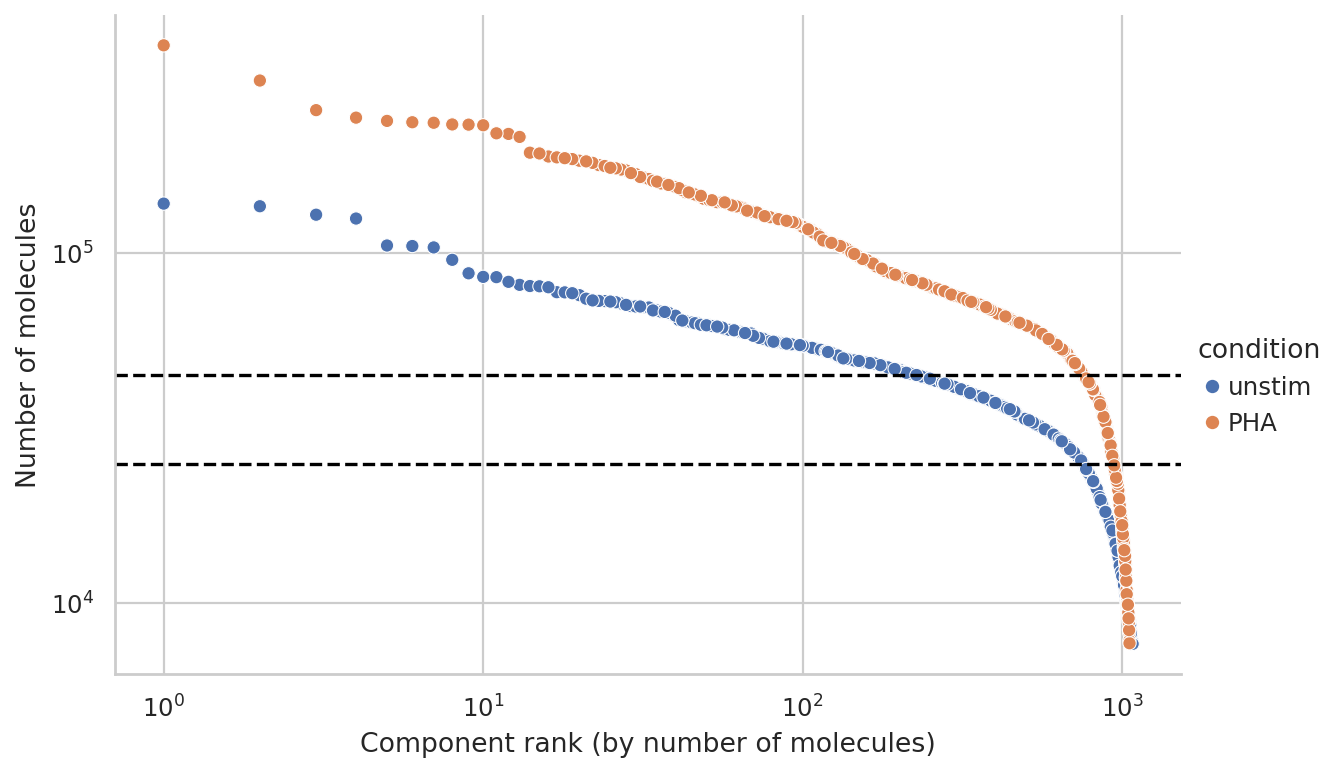

In [50]:
molecule_rank_df = adata.obs[["condition", "n_umi"]].copy()
molecule_rank_df["rank"] = molecule_rank_df.groupby(["condition"])["n_umi"].rank(
    ascending=False, method="first"
)
fig_intersection, ax = molecule_rank_plot(molecule_rank_df, group_by="condition")
molecule_thresh = {
    'PHA': 45000,
    'unstim': 25000,
   
}
for sample, thresh in molecule_thresh.items():
    ax.axhline(thresh, color='black', linestyle='--')

In [52]:
mask_by_rank=False
if mask_by_rank:
    mask = np.zeros(adata.n_obs, dtype=bool)

    for cond, thresh in molecule_thresh.items():
        cond_mask = adata.obs['condition'] == cond
        umi_mask = adata.obs['n_umi'] >= thresh
        mask |= cond_mask & umi_mask  # keep if both condition and umi threshold satisfied

    # Apply filter
    adata_filtered = adata[mask].copy()

    print(f"Kept {adata_filtered.n_obs:,} of {adata.n_obs:,} components after filtering.")
else:
    print (print(f"Kept {adata.n_obs:,} of {adata.n_obs:,} components after filtering."))

Kept 2,132 of 2,132 components after filtering.

None

In [6]:
# whitelist = []   
# detection_thresh = 0.05                


# X = adata.X.A if hasattr(adata.X, "A") else (
#     adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
# )

# # --- detection rate per protein ---
# det_rate = (X > 0).sum(axis=0) / X.shape[0]

# # --- mark proteins ---
# adata.var['detection_rate'] = det_rate
# adata.var['whitelisted'] = adata.var_names.isin(whitelist)
# adata.var['keep_protein'] = (adata.var['detection_rate'] >= detection_thresh) | adata.var['whitelisted']

# # --- list of deleted markers ---
# deleted_markers = adata.var_names[~adata.var['keep_protein']].tolist()
# print(f"Deleted {len(deleted_markers)} markers:")
# print(deleted_markers)

# # --- filter proteins ---
# adata = adata[:, adata.var['keep_protein']].copy()


In [53]:
df = pd.DataFrame(adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X,
                  index=adata.obs_names,
                  columns=adata.var_names)

# Compute global summary statistics
summary = df.describe().T[["mean", "std", "min", "25%", "50%", "75%", "max"]]
summary.head()

,mean,std,min,25%,50%,75%,max
HLA-ABC,3522.683865,4125.604541,72.0,1338.0,2180.0,4008.75,44487.0
B2M,5976.673077,5545.877467,68.0,2581.0,4340.0,7223.75,57722.0
CD11b,12.203565,29.556995,0.0,2.0,4.0,8.00,330.0
CD11c,141.371482,561.467554,0.0,3.0,8.0,26.00,7179.0
CD18,344.361163,333.841883,0.0,132.0,238.0,453.00,2731.0


In [100]:
adata.obs["total_counts"] = np.sum(adata.X, axis=1).A1 if hasattr(adata.X, "A1") else np.sum(adata.X, axis=1)

# summary statistics
summary = adata.obs["total_counts"].describe()
print(summary)

count    167542.000000
mean       6937.644692
std        8148.493285
min          58.000000
25%        1457.000000
50%        3715.000000
75%        9401.000000
max       96379.000000
Name: total_counts, dtype: float64

In [55]:
adata.layers['counts']=adata.X
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['norm_log1p']=adata.X


In [56]:
adata.layers['log1p']=adata.obsm['log1p']

# Annotation

/home/projects/nyosef/zvise/.local/share/mamba/envs/pxlgn/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning:

Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None



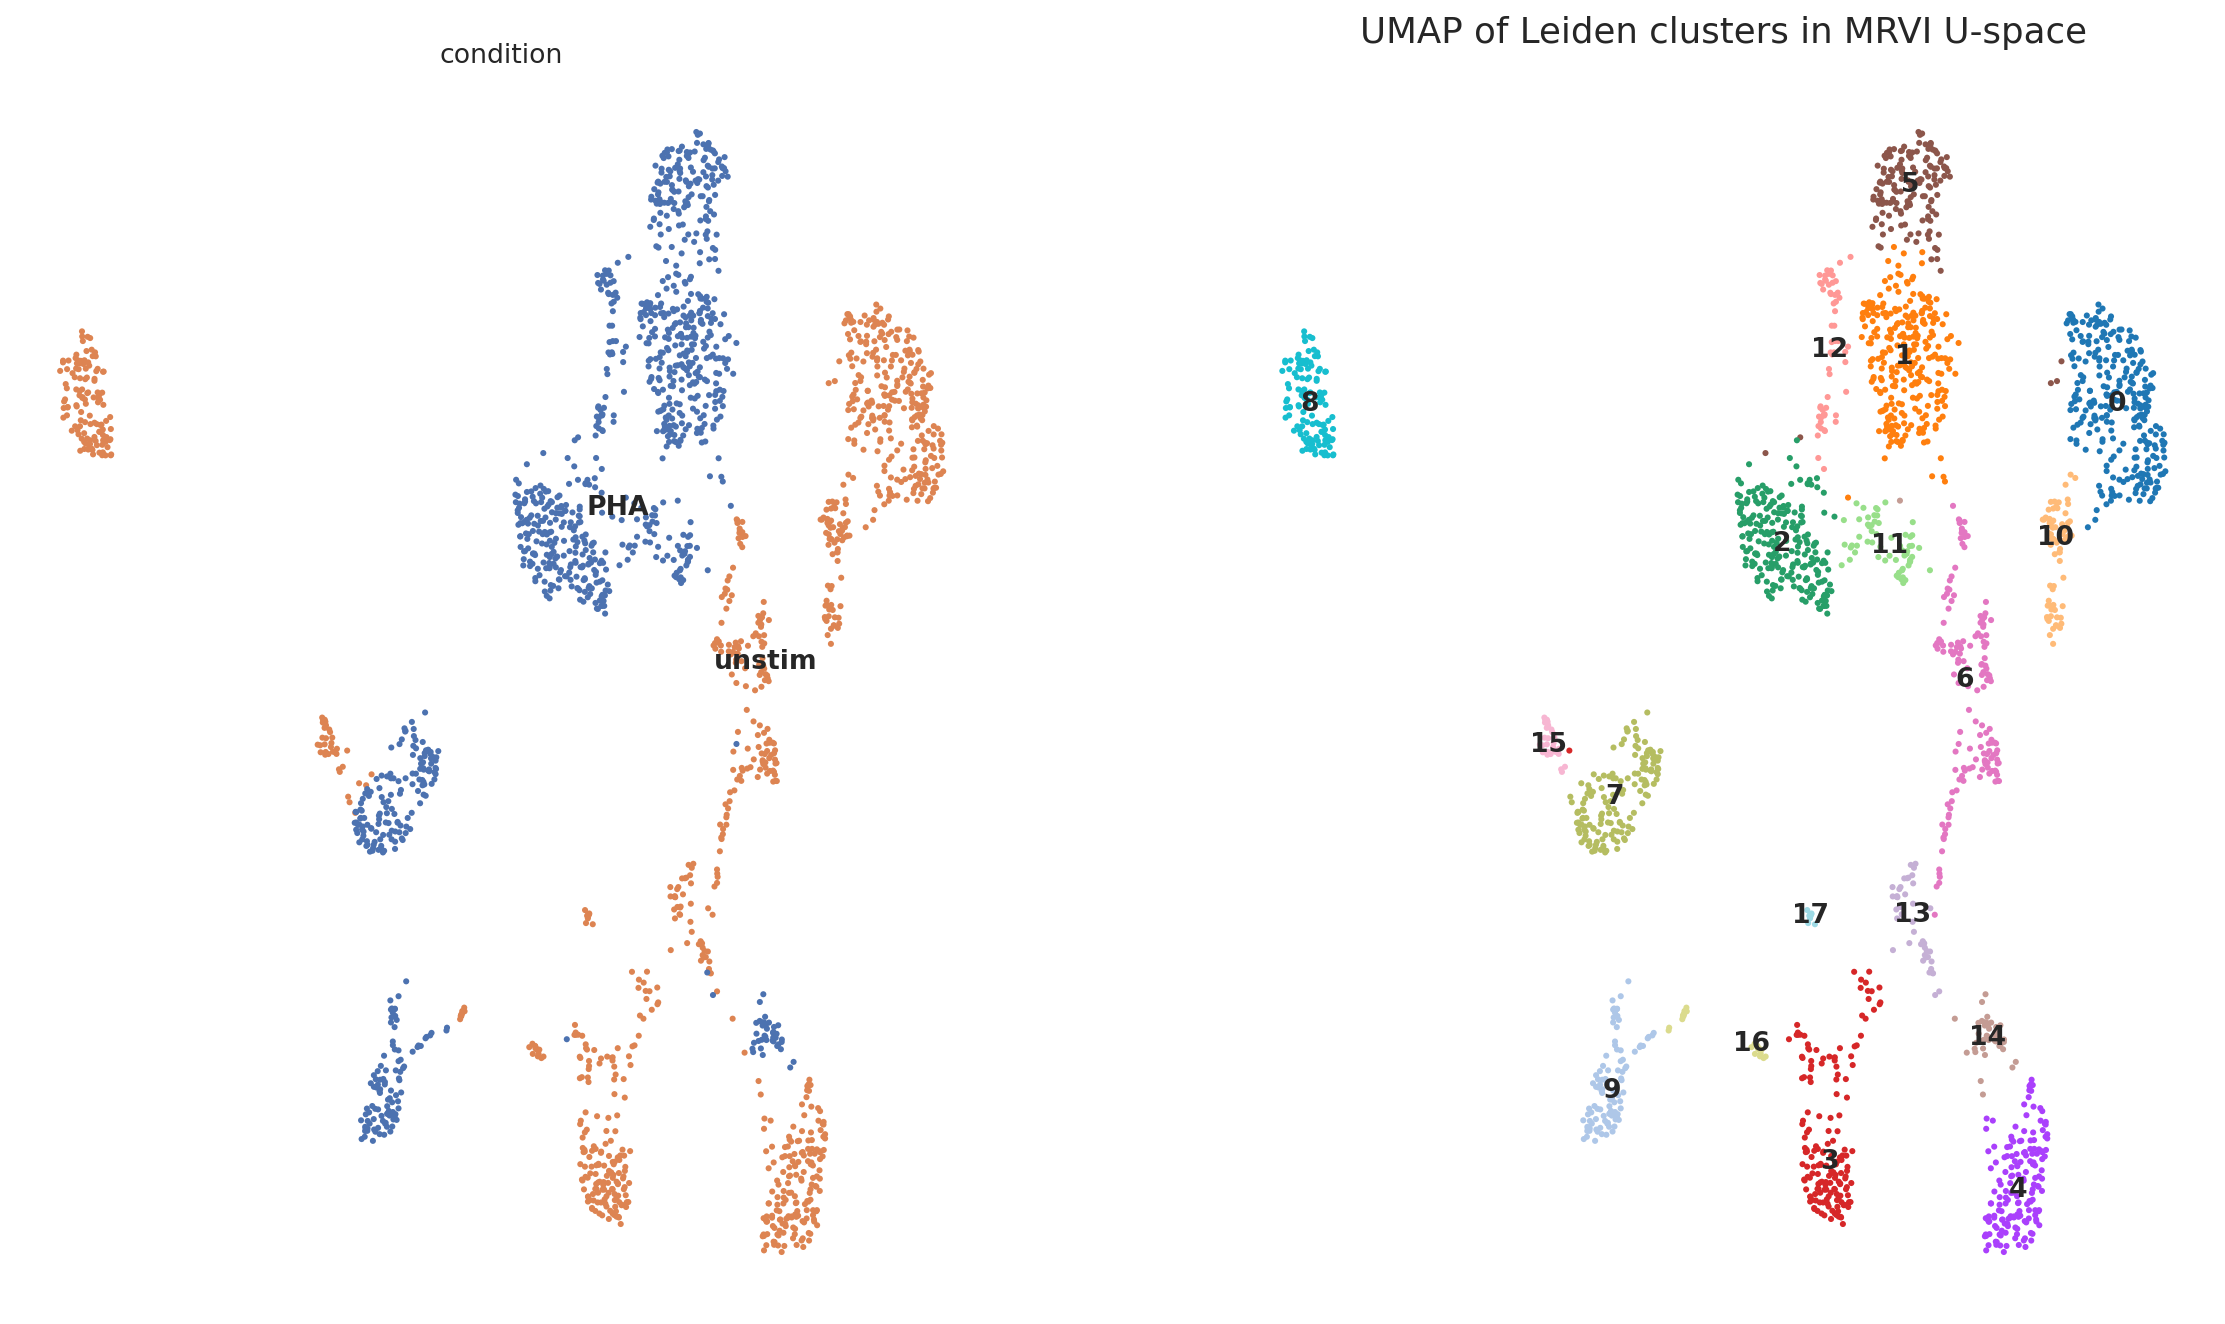

In [65]:
working_layer='norm_log1p'


sc.pp.pca(adata, n_comps=30, use_highly_variable=False, layer=working_layer)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, use_rep=None)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.6)

sc.pl.umap(adata, color=["condition",'leiden'], legend_loc='on data',frameon=False, size=30, show=False)
plt.gcf().set_size_inches(18, 10)
plt.title("UMAP of Leiden clusters in MRVI U-space", fontsize=16, pad=15)
plt.show()

In [66]:
adata_tmp = ad.AnnData(
    X=adata.layers[working_layer],
    obs=adata.obs.copy(), var=adata.var.copy()
)
sc.tl.rank_genes_groups(adata_tmp,'leiden', method="wilcoxon",)


diff_exp_df = sc.get.rank_genes_groups_df(adata_tmp, group=None)
diff_exp_df["-log10(adjusted p-value)"] = -np.log10(diff_exp_df["pvals_adj"])
diff_exp_df["Significant"] = diff_exp_df["pvals_adj"] < 0.01
diff_exp_df.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj,-log10(adjusted p-value),Significant
0,0,CD150,21.932404,2.668061,1.275115e-106,2.014682e-104,103.695793,True
1,0,CD44,19.670496,1.410775,3.859842e-86,7.623188e-85,84.117863,True
2,0,CD45RO,19.368498,3.058024,1.423488e-83,2.249111e-82,81.647989,True
3,0,CD127,18.018114,2.972784,1.404507e-72,1.386951e-71,70.857939,True
4,0,CD82,17.568508,1.708756,4.293203e-69,3.768478e-68,67.423834,True


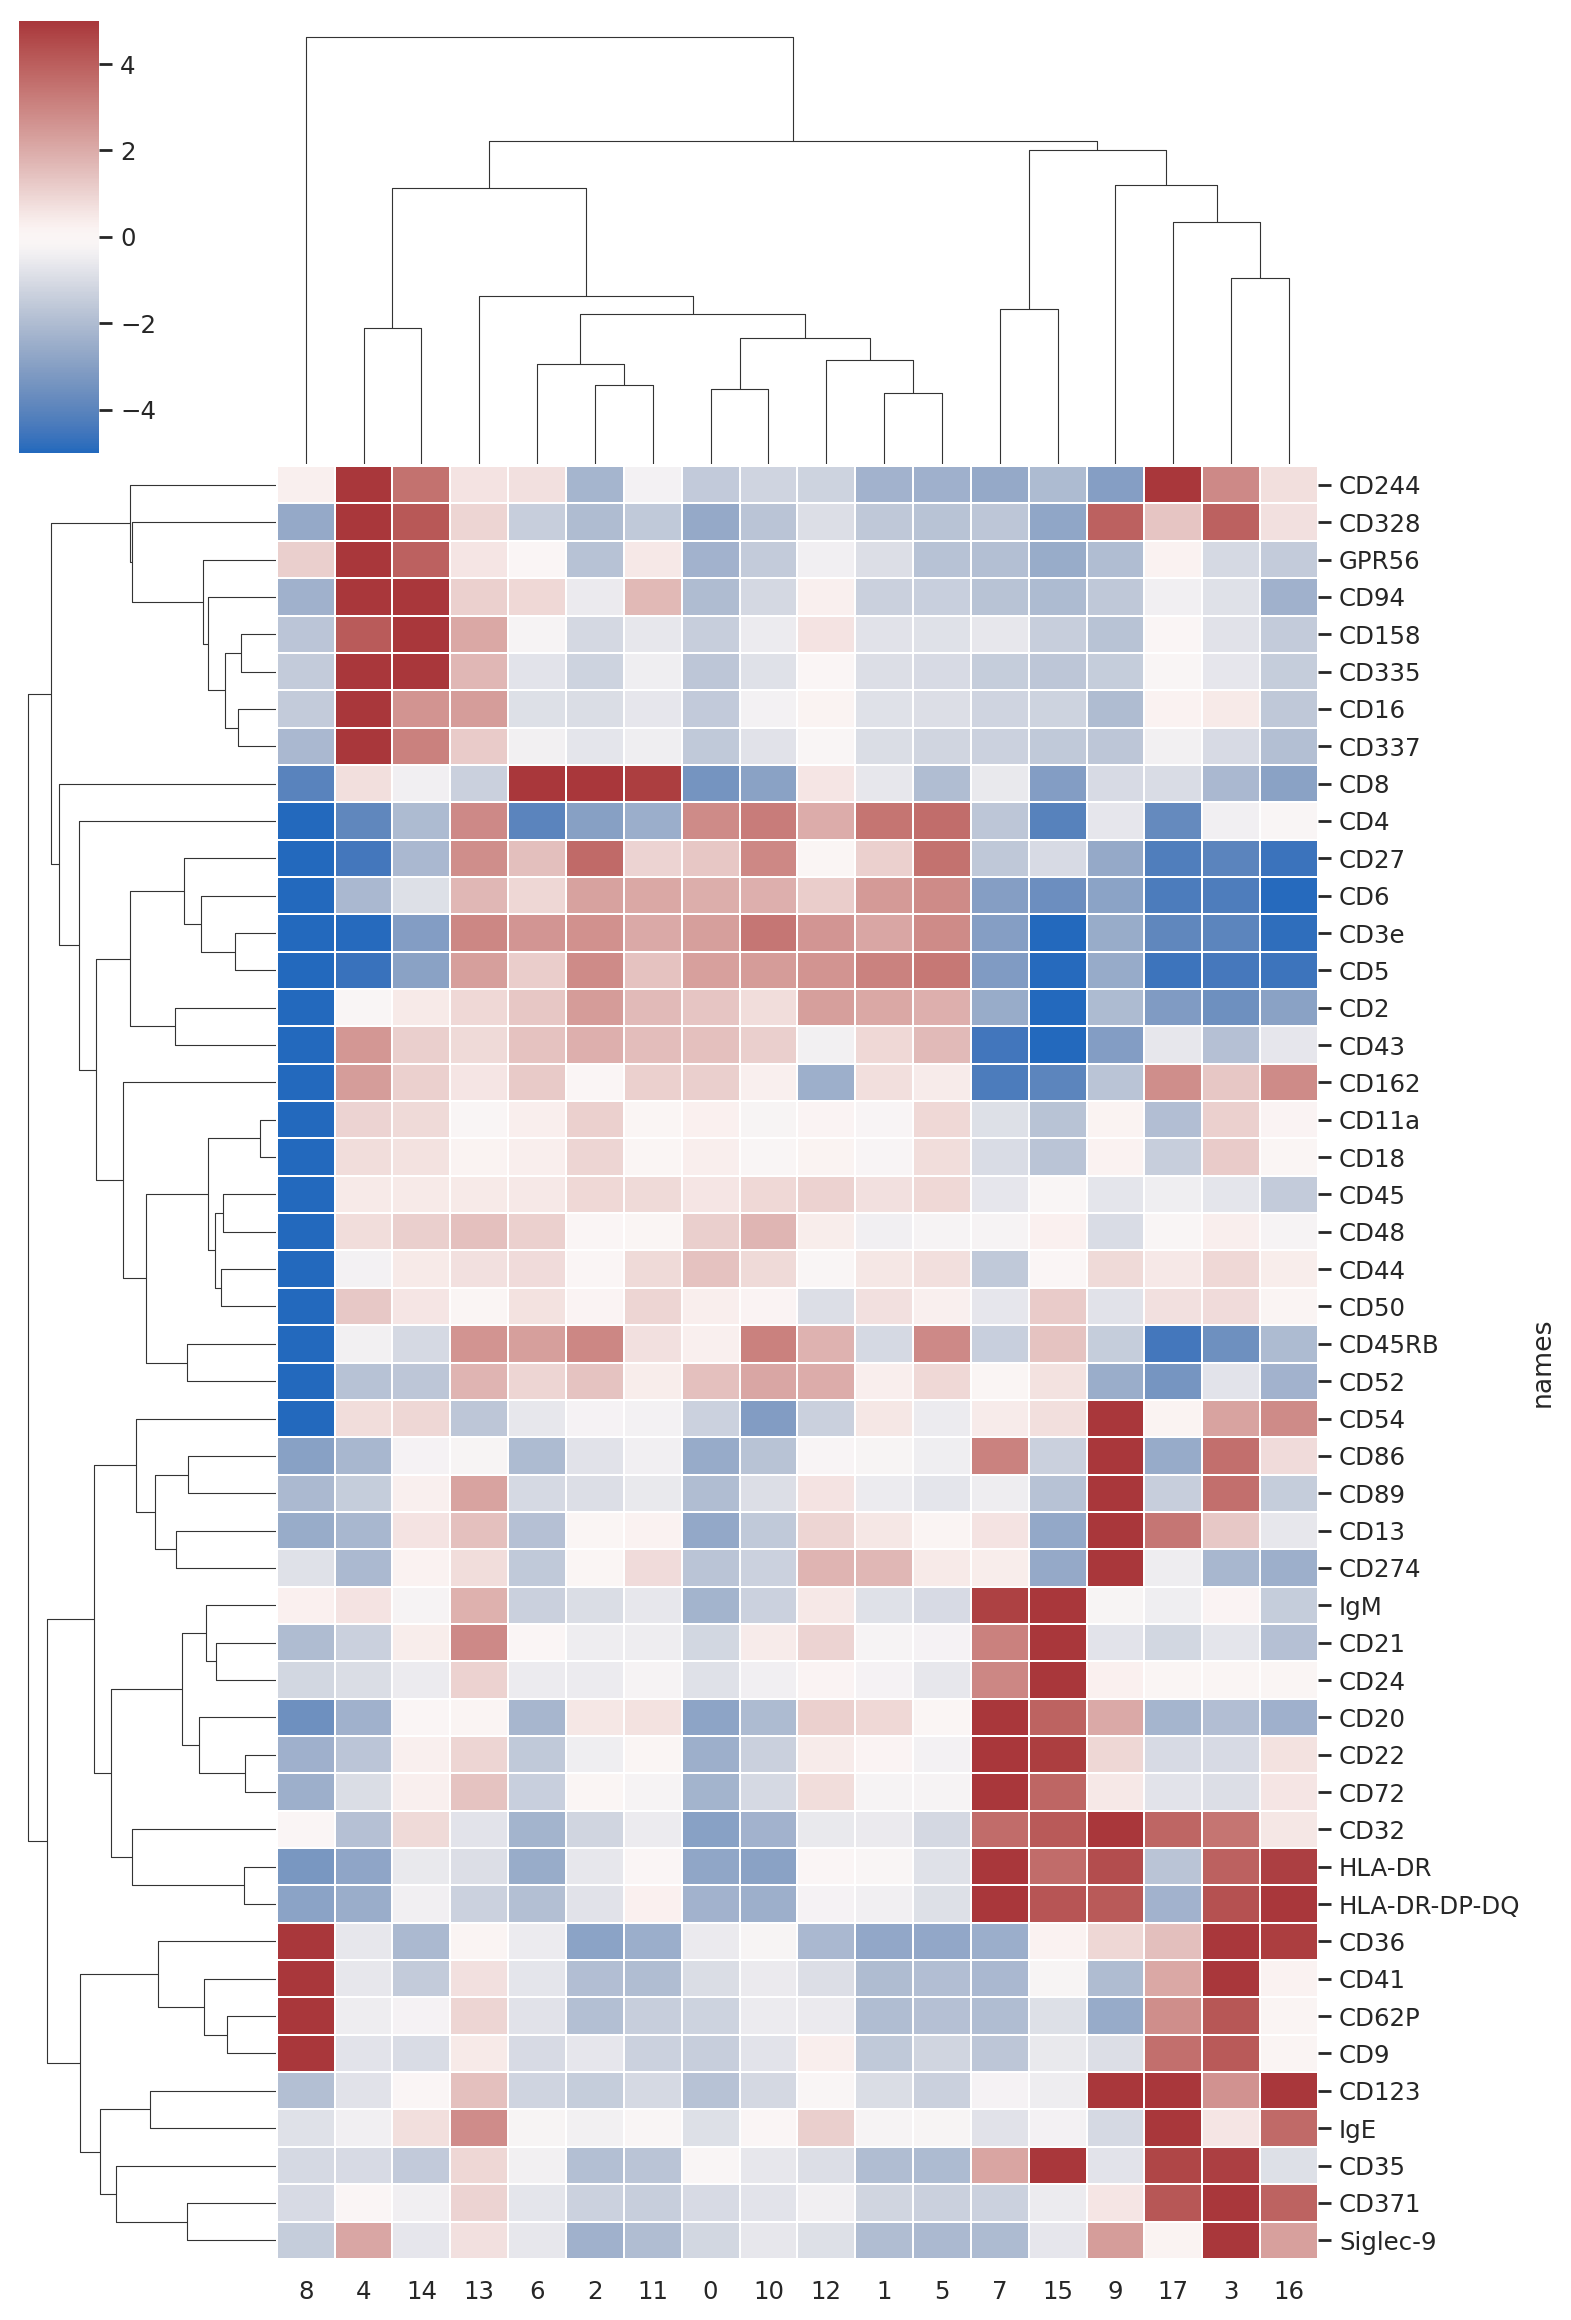

In [67]:
df = diff_exp_df.pivot(index=["names"], columns=["group"], values=["logfoldchanges"])

markers_for_heatmap = set(
    diff_exp_df[
        (np.abs(diff_exp_df["logfoldchanges"]) > 5) & diff_exp_df["Significant"]
    ]["names"]
)
markers_to_add=[]

markers_for_heatmap.update(markers_to_add)

df = df[df.index.isin(markers_for_heatmap)]

df.columns = [cluster for _, cluster in df.columns]
fig = sns.clustermap(df, yticklabels=True, linewidths=0.1, cmap="vlag", vmin=-5, vmax=5);
fig.fig.set_size_inches(10, 15)

In [68]:
cell_annotations = {
    "0": "CD4_unstim",
    "4": "NK_unsim",
    "1": "CD4_PHA",
    "2": "CD8_PHA",
    "3": "platelet-monocyte_umstim",
    "4": "NK_unstim",
    "5": "CD4_PHA",
    "6": "CD8_ustim",
    "7": "B_naive_PHA",
    "8": "Platelets",
    "9": "APC_active_PHA",
    "10": "CD4_unstim",
    "11": "CD8_PHA",
    "12": "CD4_PHA",
    "13": "CD4_unstim",
    "14": "NK_PHA",
    "15": "B_naive_unstim",
    "16": "basophil–monocyte_unstim",
    "17": "Basophiles",

     
}


adata.obs["cell_type"] = adata.obs[
    "leiden"
].map(cell_annotations)

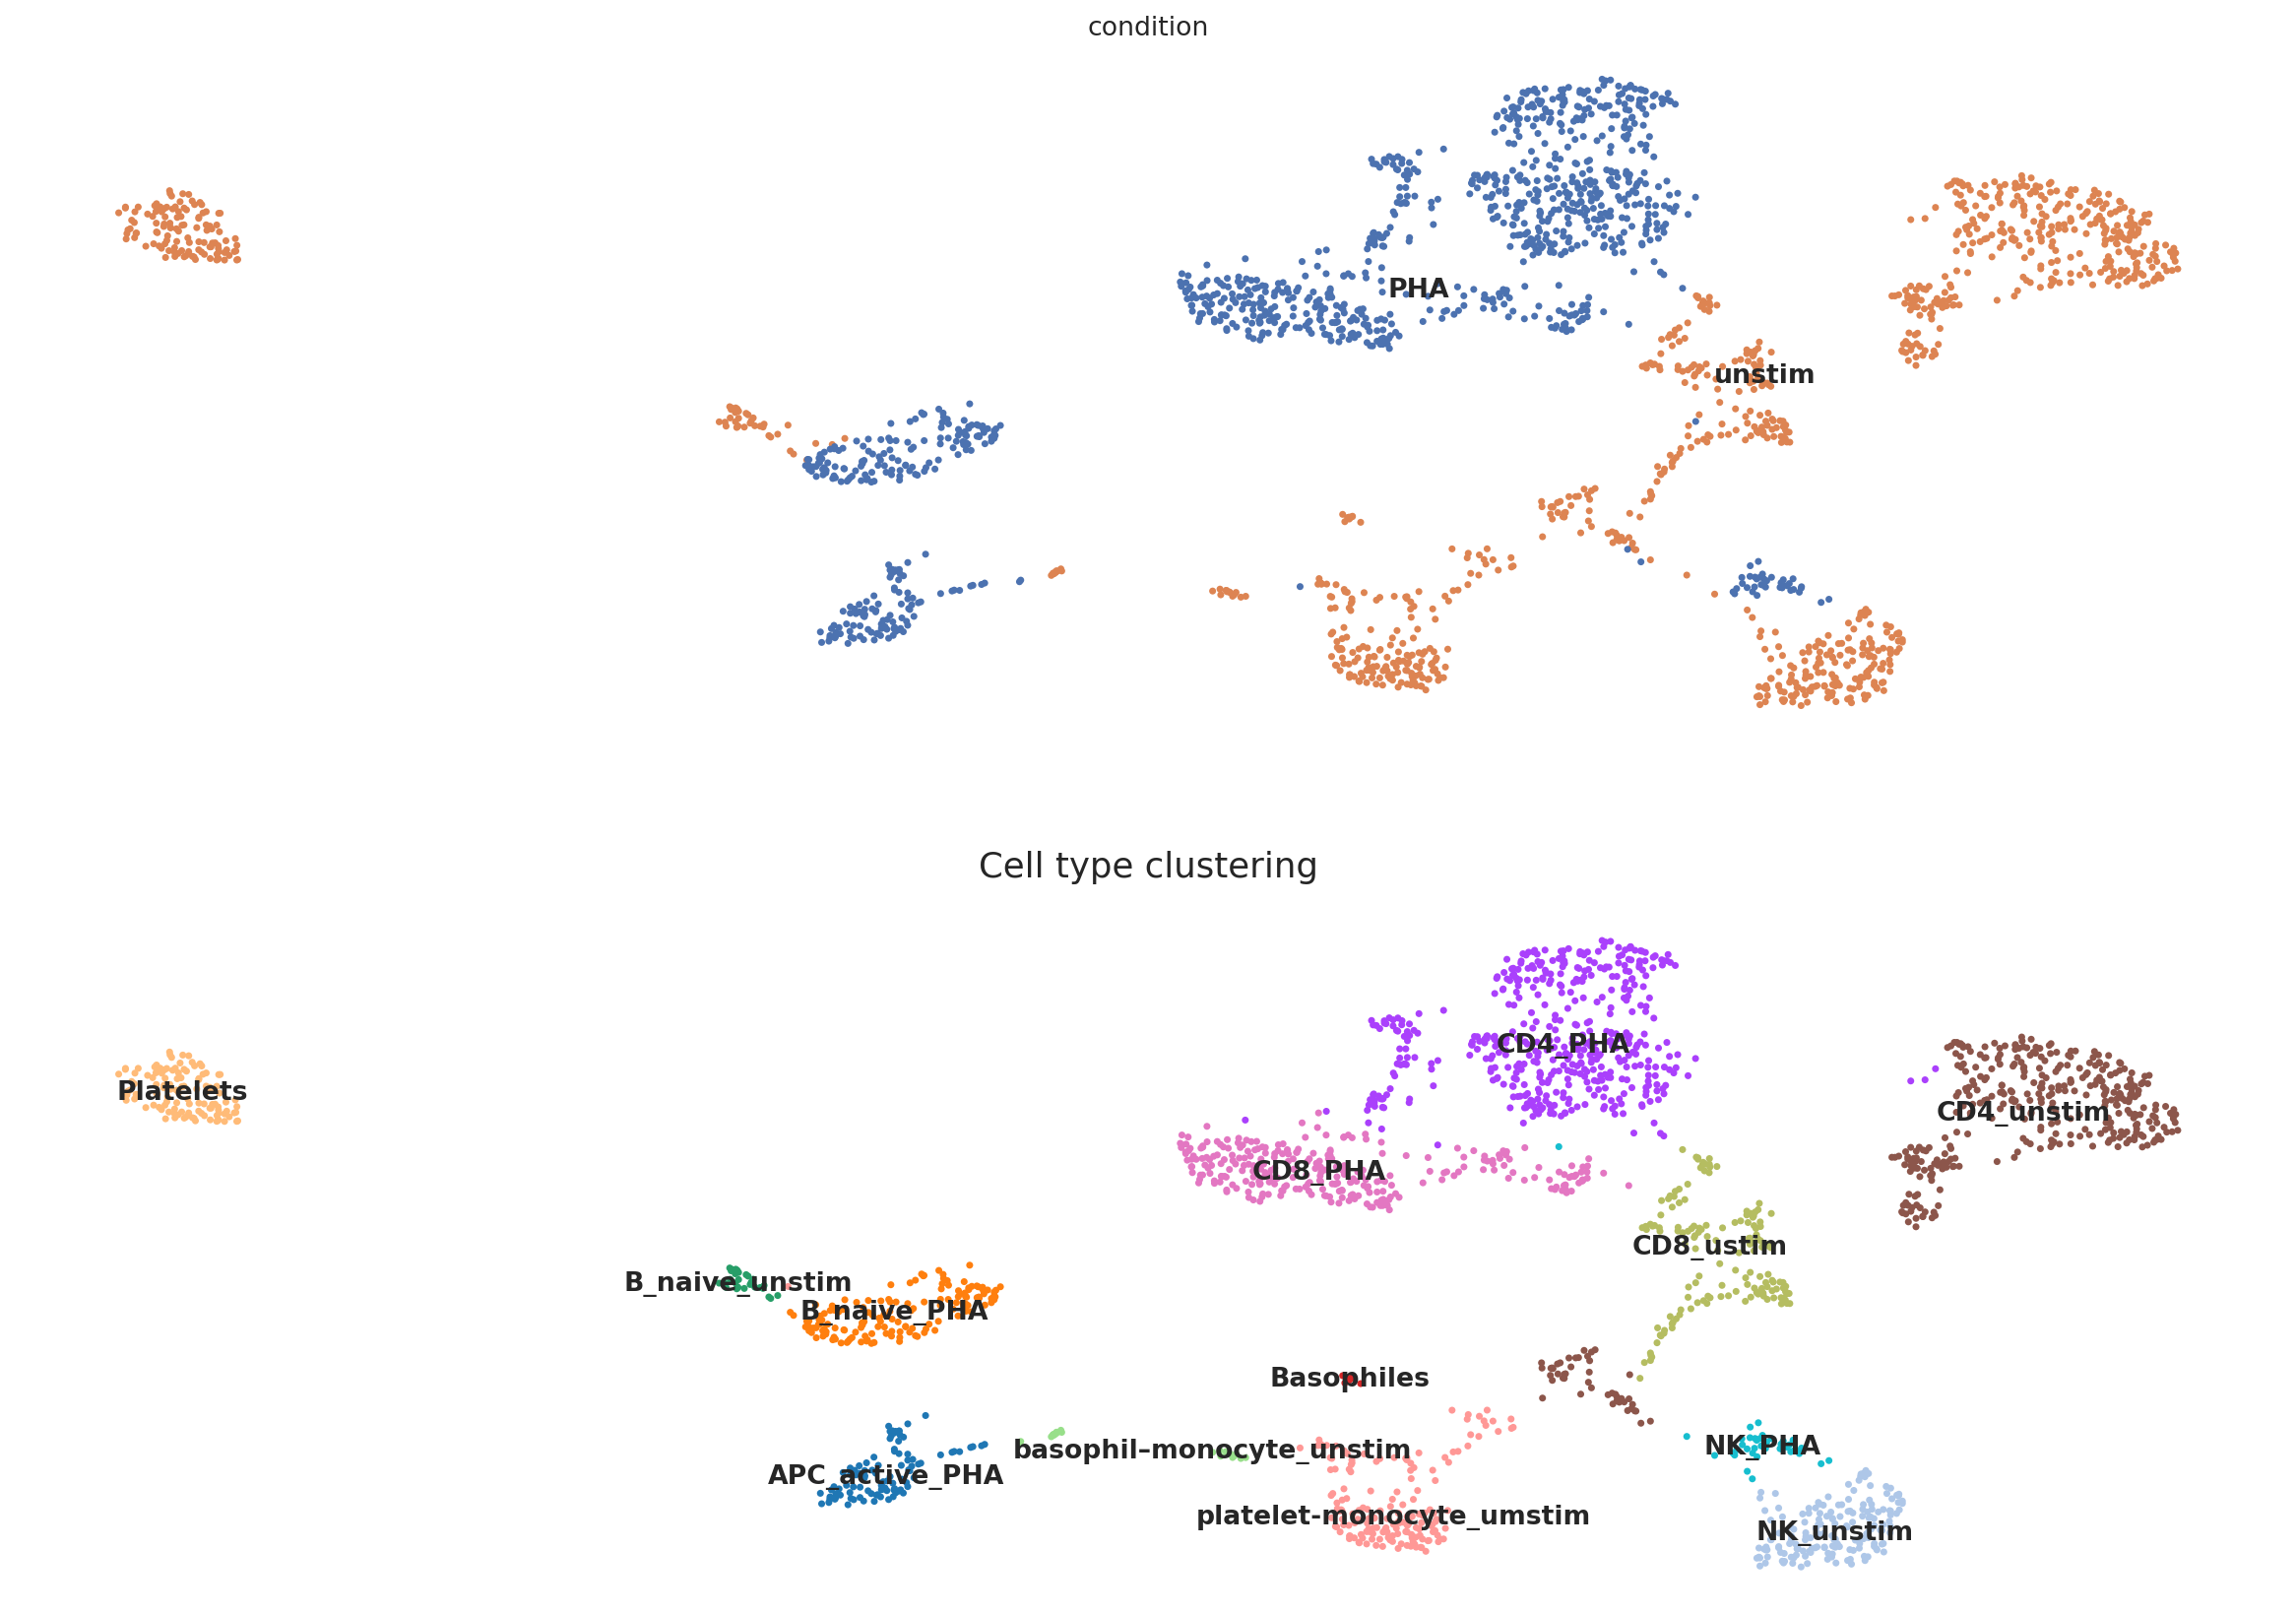

In [69]:
sc.pl.umap(adata, color=["condition",'cell_type'], legend_loc='on data',frameon=False, size=40,ncols=1,show=False)
plt.gcf().set_size_inches(20, 12)
plt.title("Cell type clustering", fontsize=16, pad=15)
plt.show()

# SPATIAL

In [70]:
spatial=data.proximity().to_df()
print (spatial.shape)
spatial = spatial[
    (spatial["min_count"]>=50) &
    (spatial["join_count_expected_mean"]>=10)
]
spatial = spatial[spatial["component"].isin(adata.obs.index)].copy()

print (spatial.shape)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(7565531, 15)

(1275449, 15)

In [17]:
# PROTEIN_PREVALENCE_FRAC = 0.05   

# n_components = adata.n_obs
# min_components = max(1, int(np.ceil(PROTEIN_PREVALENCE_FRAC * n_components)))

# prot_counts_1 = spatial.reset_index().groupby('marker_1')['component'].nunique()
# prot_counts_2 = spatial.reset_index().groupby('marker_2')['component'].nunique()

# prot_counts = prot_counts_1.add(prot_counts_2, fill_value=0).astype(int)

# proteins_to_keep = prot_counts[prot_counts >= min_components].index.tolist()
# proteins_to_drop = prot_counts[prot_counts < min_components].index.tolist()

# print(f"[Proteins] kept: {len(proteins_to_keep)}, dropped: {len(proteins_to_drop)}")
# print("Dropped proteins:", proteins_to_drop)

# uncut_size=spatial.shape[0]
# print (spatial.shape)

# spatial = spatial[
#     spatial['marker_1'].isin(proteins_to_keep) &
#     spatial['marker_2'].isin(proteins_to_keep)
# ].copy()

# cut_size=spatial.shape[0]
# print (spatial.shape)
# print (f'propotion of remaining pairs:{cut_size / uncut_size}')

In [18]:
spatial[(spatial.marker_1=='B2M')&(spatial.marker_2=='CD11a')&(spatial.component=='9567c4b0b99c07ab')]


,marker_1,marker_2,join_count,join_count_expected_mean,join_count_expected_sd,join_count_z,join_count_p,component,sample,marker_1_count,marker_1_freq,marker_2_count,marker_2_freq,min_count,log2_ratio
5488338,B2M,CD11a,72,59.39,8.755829,1.440183,0.074908,9567c4b0b99c07ab,PNA062_PHA_PBMCs_1000cells_S04_S4,3672,0.148142,108,0.004357,108,0.277777


In [19]:
def _pivot_joinz(spatial, col="join_count_z"):
    # pair label "marker_1/marker_2" (already ordered as user promised)
    tmp = spatial.reset_index().copy()  # expects index name 'component'
    tmp["pair"] = tmp["marker_1"].astype(str) + "/" + tmp["marker_2"].astype(str)
    wide = tmp.pivot_table(index="component", columns="pair", values=col, aggfunc="first")
    return wide

def build_spz_obsm(
    adata,
    spatial,                 
    col="join_count_z",
    asinh_scale=3.0
):
    wide = _pivot_joinz(spatial, col=col)
    wide = wide.reindex(index=adata.obs_names)  # align with adata.obs
    
    wide = wide.fillna(0.0)

    adata.obsm["spatial_id"] = wide.astype(np.float32)

    a = float(asinh_scale)
    adata.obsm["spatial_arcsinh"] = np.arcsinh(wide / a).astype(np.float32)

    print(f"Stored DataFrames in .obsm with shape {wide.shape} (cells × pairs)")


build_spz_obsm(
    adata,
    spatial,            # long-form table (index='component')
    col="join_count_z",
    asinh_scale=3.0
)


Stored DataFrames in .obsm with shape (2132, 7500) (cells × pairs)

In [20]:
spatial_df = adata.obsm["spatial_arcsinh"]

tmp = ad.AnnData(X=spatial_df.values, obs=adata.obs.copy(), var=pd.DataFrame(index=spatial_df.columns))

sc.pp.highly_variable_genes(tmp, n_top_genes=2000, flavor="seurat", subset=False)

top_cols = tmp.var[tmp.var["highly_variable"]].index

adata.obsm["spatial_arcsinh_2000"] = spatial_df[top_cols].copy()

print(f"Selected {len(top_cols)} most variable spatial-pair features using Scanpy HVG.")


/home/projects/nyosef/zvise/.local/share/mamba/envs/pxlgn/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:305: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Selected 2000 most variable spatial-pair features using Scanpy HVG.

/tmp/ipykernel_381702/4171985783.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


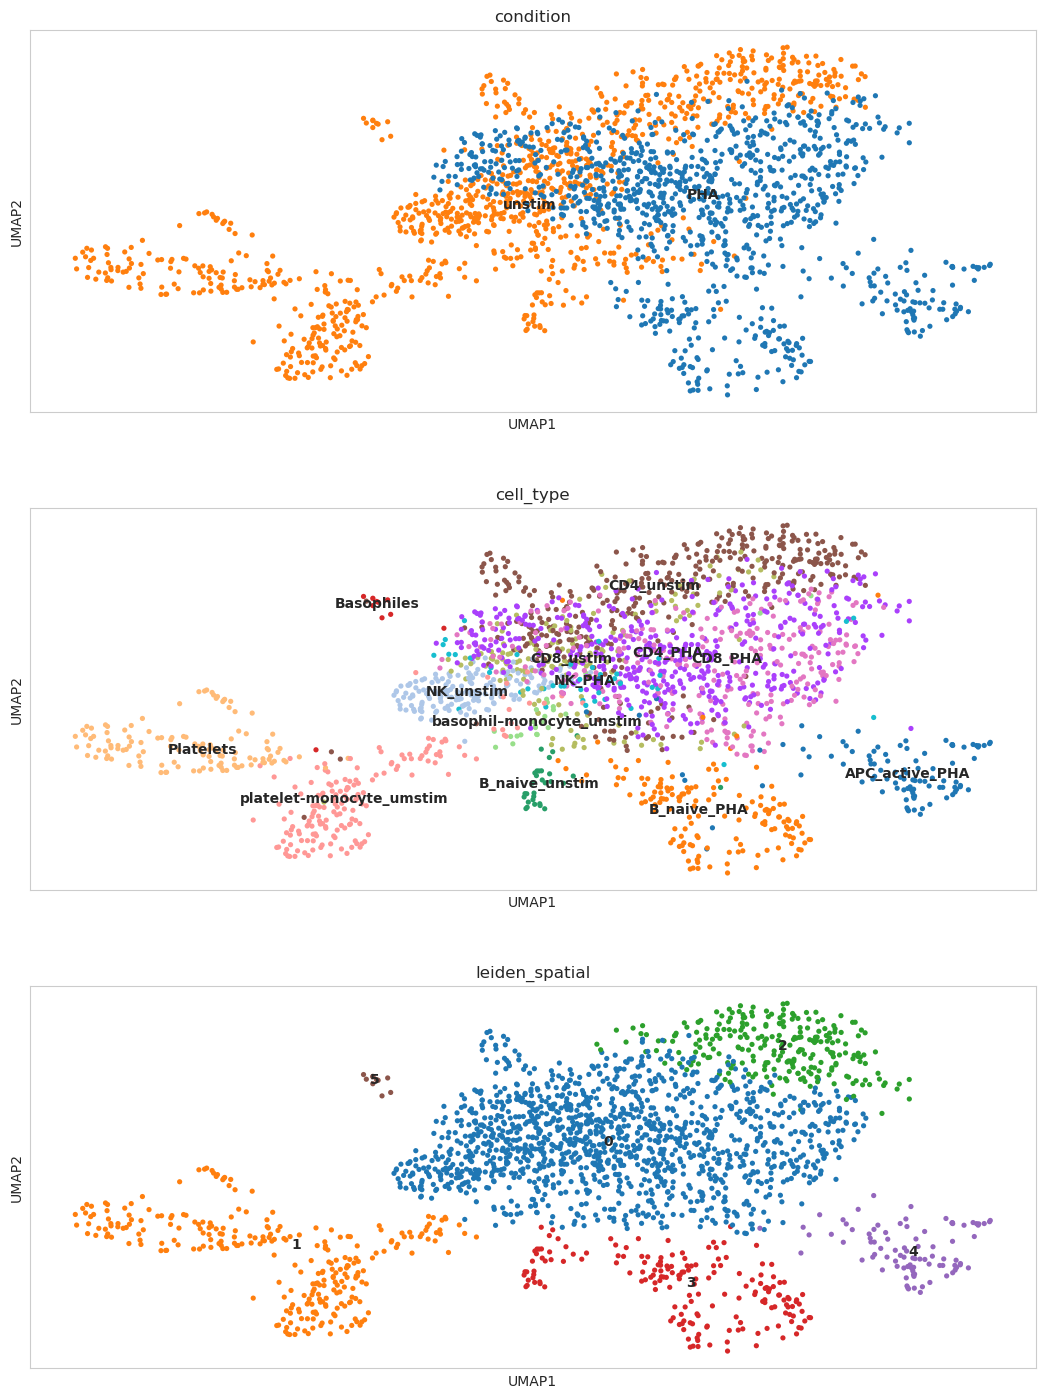

In [24]:

sc.pp.neighbors(adata, n_neighbors=15, use_rep="spatial_arcsinh_2000")
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.4, random_state=0, key_added='leiden_spatial')
sc.pl.umap(
    adata,
    color=['condition','cell_type','leiden_spatial'],
    ncols=1,
    legend_loc='on data',
    show=False,
    
)
plt.gcf().set_size_inches(14, 16)

plt.tight_layout()
plt.show()

In [115]:
ADATA_FOR_MODEL_PATH='/home/projects/nyosef/zvise/PixelGen/PixelGen/Data/adatas/PBMC_adata_for_model.h5ad'
adata.write_h5ad(ADATA_FOR_MODEL_PATH)

# MODEL

In [57]:
ADATA_FOR_MODEL_PATH='/home/projects/nyosef/zvise/PixelGen/PixelGen/Data/adatas/PBMC_adata_for_model.h5ad'

load_model=True
if load_model:
    adata=sc.read_h5ad(ADATA_FOR_MODEL_PATH)
    adata
else:
    print(adata)
    
adata.obsm['pca'] = PCA(n_components=30).fit_transform(adata.X)


### REGULAR MODEL

INFO     Using column names from columns of adata.obsm['spatial_id']                                               


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/projects/nyosef/zvise/.local/share/mamba/envs/pxlgn/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/10000 [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


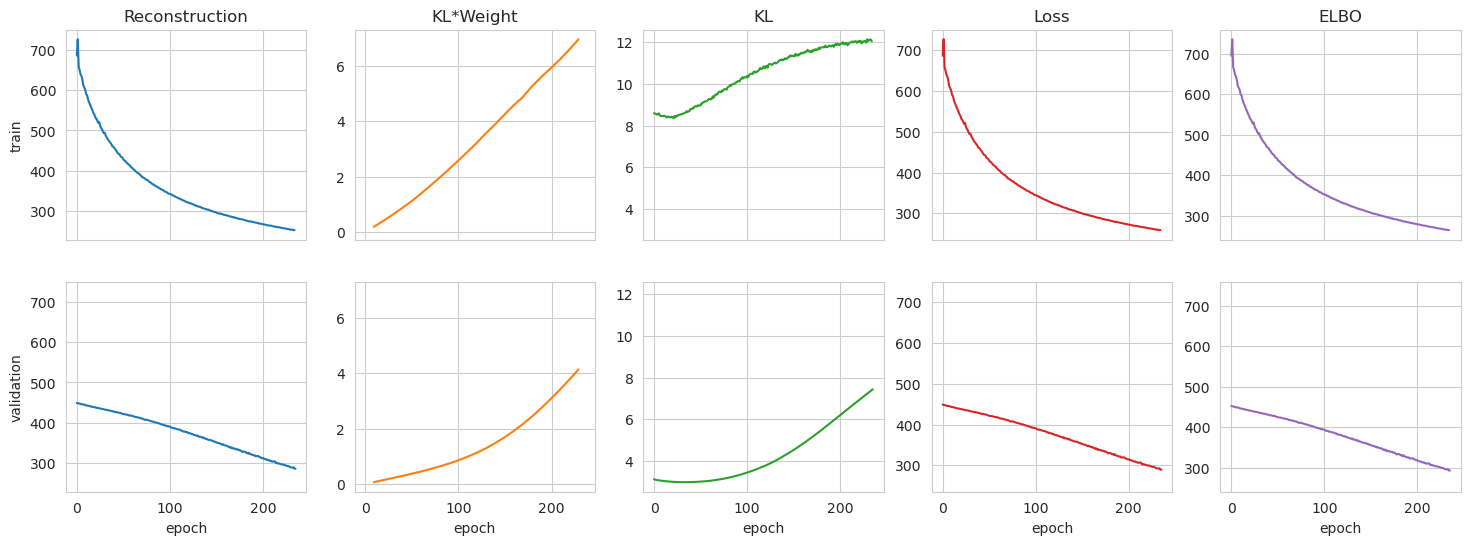

In [ ]:
model_cls = MultiModalSCVI
abundance_layer = 'norm_log1p'
spatial_layer='spatial_id'
max_epochs=10000

latent_name=f'weighted_latent'
    
setup_kwargs = dict(layer=abundance_layer, extra_modality_keys=[spatial_layer], n_modalities=2, batch_key='condition', spatial_mask_key=None,  )
model_kwargs = dict(n_latent=30, n_hidden=128, n_layers=2, dropout_rate=0.1, 
                            distrs=[D.Normal, D.Normal], 
                            
                            loss_weights='auto',
                            joint_kl=False, unimodal_kl=True,
                            
                            decoder_kwargs=dict(decoder_param_eps=1e-2, decoder_activation='exp')
                        )
train_kwargs = dict(train_size=0.8, check_val_every_n_epoch=1, early_stopping=True, 
                        early_stopping_patience=200, batch_size=2000,
                        max_epochs=max_epochs, enable_checkpointing=True, 
                        plan_kwargs=dict(lr=1e-4, optimizer='Adam', n_epochs_kl_warmup=400)
                    )
model = train_model(adata, model_cls=model_cls, setup_kwargs=setup_kwargs, model_kwargs=model_kwargs, train_kwargs=train_kwargs,)

In [50]:
model.save('/home/projects/nyosef/zvise/PixelGen/PixelGen/Data/models/all_spatial_id',overwrite=True)

In [51]:
imputed = model.get_normalized_expression(
    adata=adata,
    return_mean_expression=True,
    return_l2_error=True,
    return_px_distrs=False,
    return_numpy=True
)

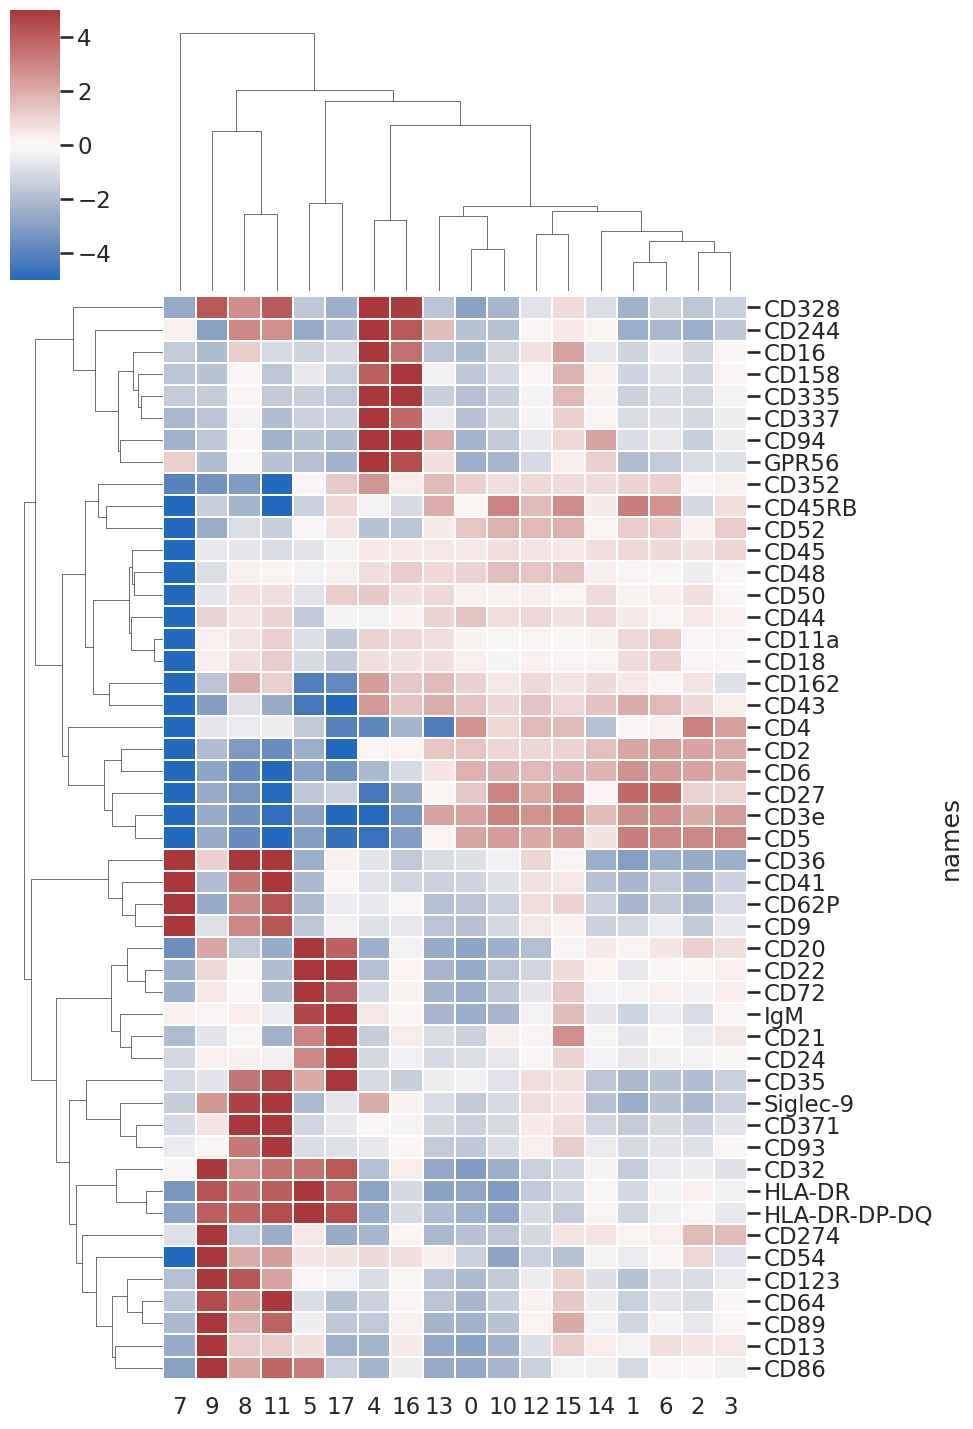

In [76]:
adata_tmp = ad.AnnData(
    X=adata.layers['norm_log1p'],
    obs=adata.obs.copy(), var=adata.var.copy()
)
sc.tl.rank_genes_groups(adata_tmp,'leiden_z', method="wilcoxon",)


diff_exp_df = sc.get.rank_genes_groups_df(adata_tmp, group=None)
diff_exp_df["-log10(adjusted p-value)"] = -np.log10(diff_exp_df["pvals_adj"])
diff_exp_df["Significant"] = diff_exp_df["pvals_adj"] < 0.01
df = diff_exp_df.pivot(index=["names"], columns=["group"], values=["logfoldchanges"])

markers_for_heatmap = set(
    diff_exp_df[
        (np.abs(diff_exp_df["logfoldchanges"]) > 5) & diff_exp_df["Significant"]
    ]["names"]
)
markers_to_add=[]

markers_for_heatmap.update(markers_to_add)

df = df[df.index.isin(markers_for_heatmap)]

df.columns = [cluster for _, cluster in df.columns]
fig = sns.clustermap(df, yticklabels=True, linewidths=0.1, cmap="vlag", vmin=-5, vmax=5);
fig.fig.set_size_inches(10, 15)

In [53]:
metrics=MultiModalVIMetrics(
    adata,
    {'model':model},
    pca_key='pca',
    batch_key='condition'
)

metrics.run()

Modalities indentified: ['norm_log1p', 'spatial_id']


/home/projects/nyosef/zvise/.local/share/mamba/envs/pxlgn/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
Embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

INFO     APC_active_PHA consists of a single batch or is too small. Skip.                                          
INFO     B_naive_unstim consists of a single batch or is too small. Skip.                                          
INFO     Basophiles consists of a single batch or is too small. Skip.                                              
INFO     CD8_PHA consists of a single batch or is too small. Skip.                                                 
INFO     NK_unstim consists of a single batch or is too small. Skip.                                               
INFO     Platelets consists of a single batch or is too small. Skip.                                               


/home/projects/nyosef/zvise/.local/share/mamba/envs/pxlgn/lib/python3.10/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
/home/projects/nyosef/zvise/.local/share/mamba/envs/pxlgn/lib/python3.10/site-packages/scib_metrics/metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings:  50%|█████     | 1/2 [00:02<00:02,  2.92s/it]

INFO     APC_active_PHA consists of a single batch or is too small. Skip.                                          
INFO     B_naive_unstim consists of a single batch or is too small. Skip.                                          
INFO     Basophiles consists of a single batch or is too small. Skip.                                              
INFO     CD8_PHA consists of a single batch or is too small. Skip.                                                 
INFO     NK_unstim consists of a single batch or is too small. Skip.                                               
INFO     Platelets consists of a single batch or is too small. Skip.                                               


/home/projects/nyosef/zvise/.local/share/mamba/envs/pxlgn/lib/python3.10/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
/home/projects/nyosef/zvise/.local/share/mamba/envs/pxlgn/lib/python3.10/site-packages/scib_metrics/metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings: 100%|██████████| 2/2 [00:05<00:00,  2.70s/it]


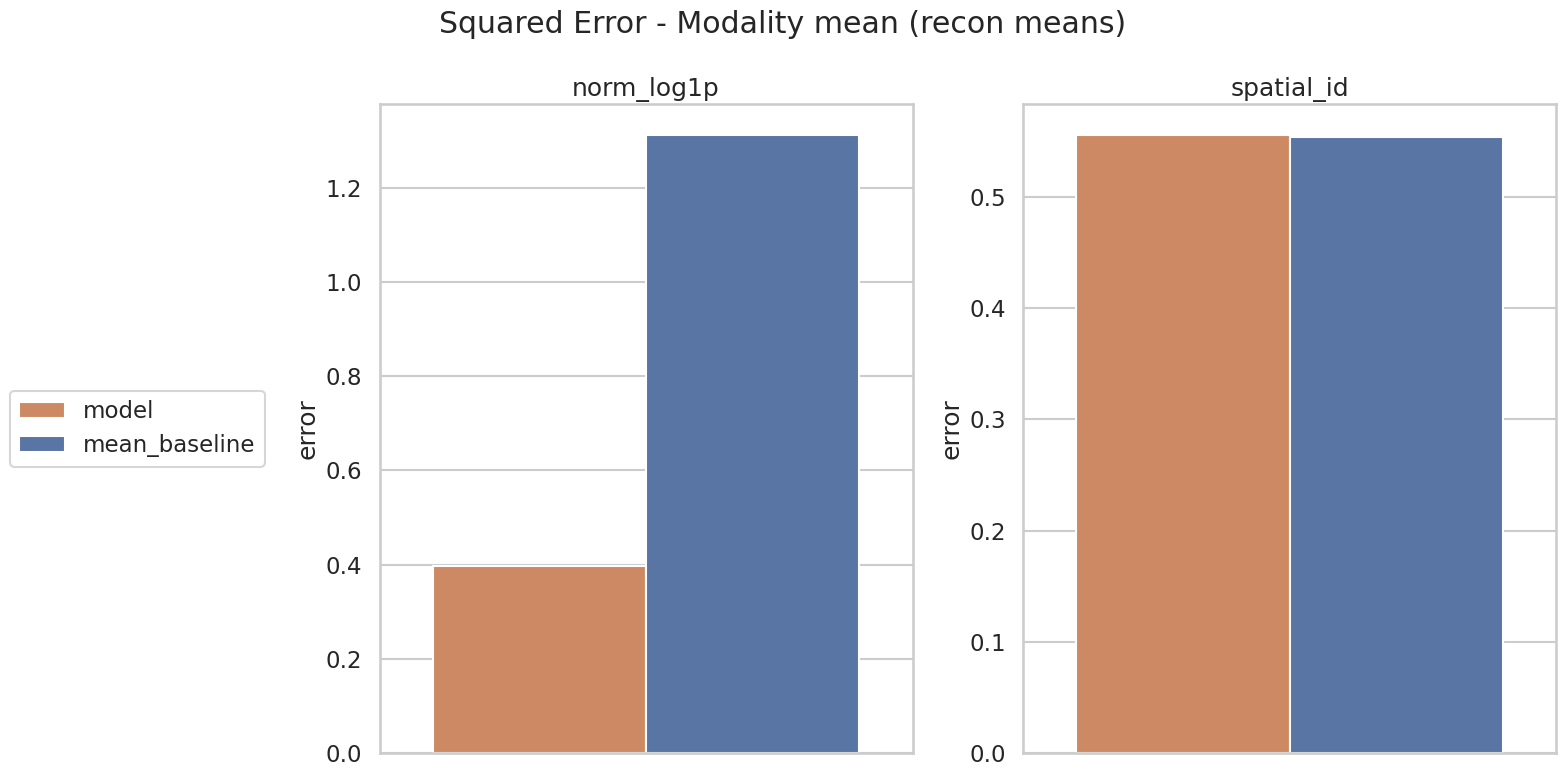

In [54]:
_ = metrics.mean_modality_errors_barplot(reconstruction_mean=True)

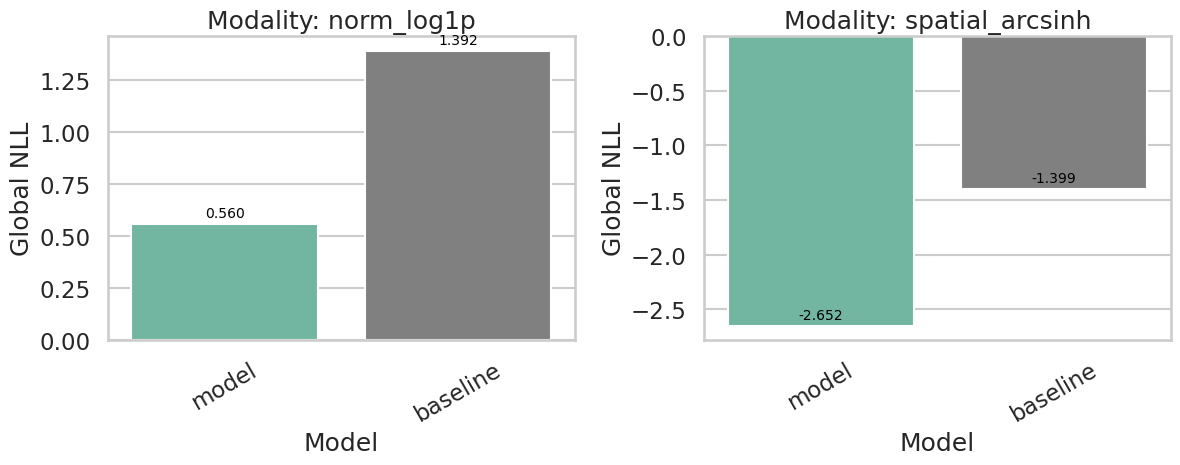

In [45]:
metrics.plot_negative_likelihood()

,NMI,ARI,Calinski_Harabasz,Davies_Bouldin,Silhouette
latent,,,,,
model,0.717097,0.569855,654.657837,1.052345,0.384687
pca,0.783113,0.639191,534.001465,1.400578,0.285440


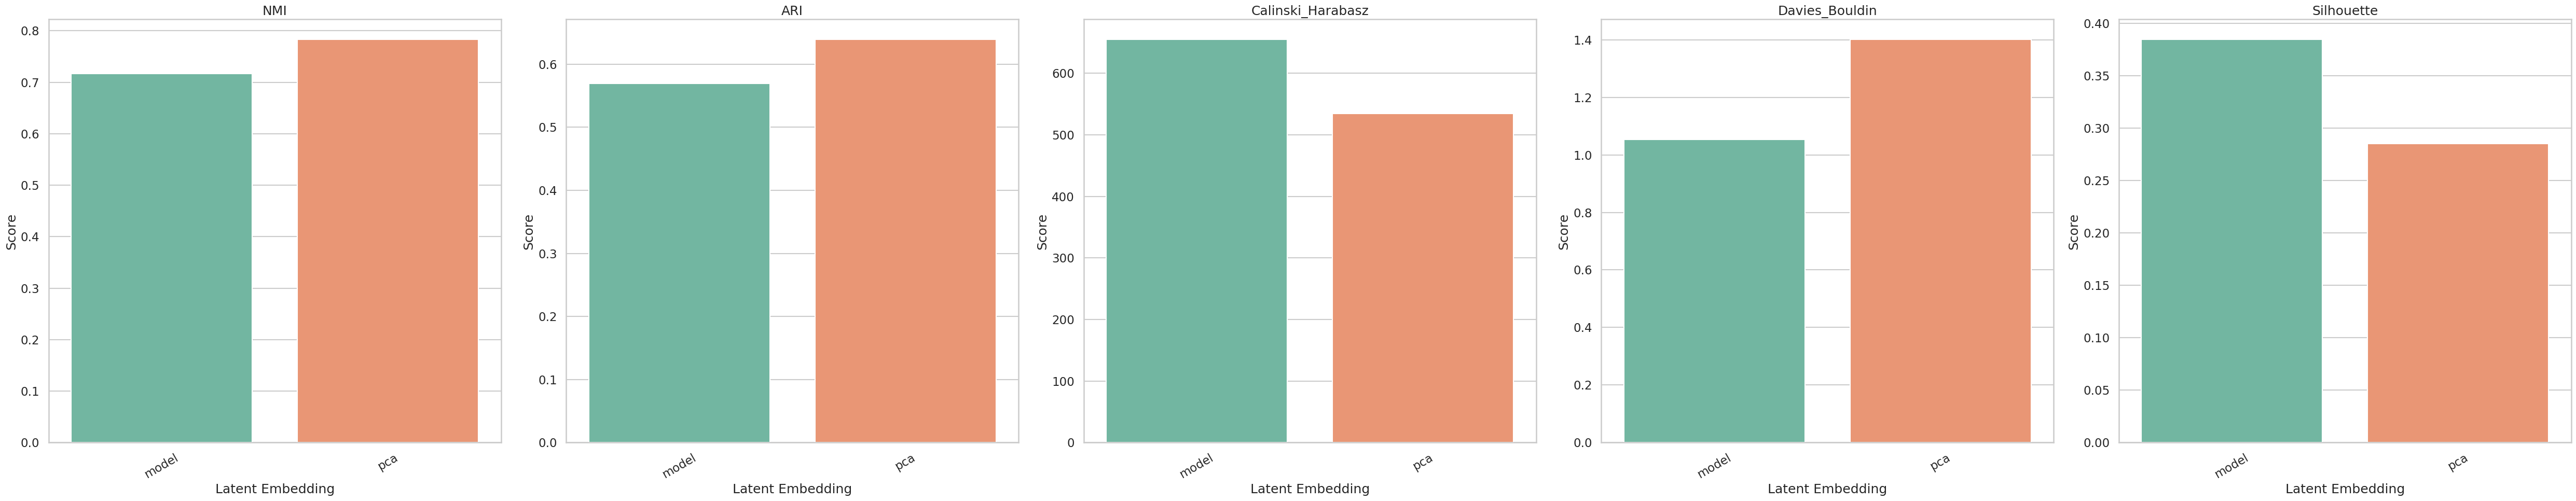

In [55]:
df = metrics.plot_latent_quality_metrics()
display (df)

/home/projects/nyosef/zvise/.local/share/mamba/envs/pxlgn/lib/python3.10/site-packages/scib_metrics/benchmark/_core.py:295: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[_METRIC_TYPE, per_class_score.columns] = _AGGREGATE_SCORE
/home/projects/nyosef/zvise/.local/share/mamba/envs/pxlgn/lib/python3.10/site-packages/scib_metrics/benchmark/_core.py:295: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[_METRIC_TYPE, per_class_score.columns] = _AGGREGATE_SCORE
/home/projects/nyosef/zvise/.local/share/mamba/envs/pxlgn/lib/python3.10/site-packages/scib_metrics/benchmark/_core.py:295: FutureWarning: Setting a

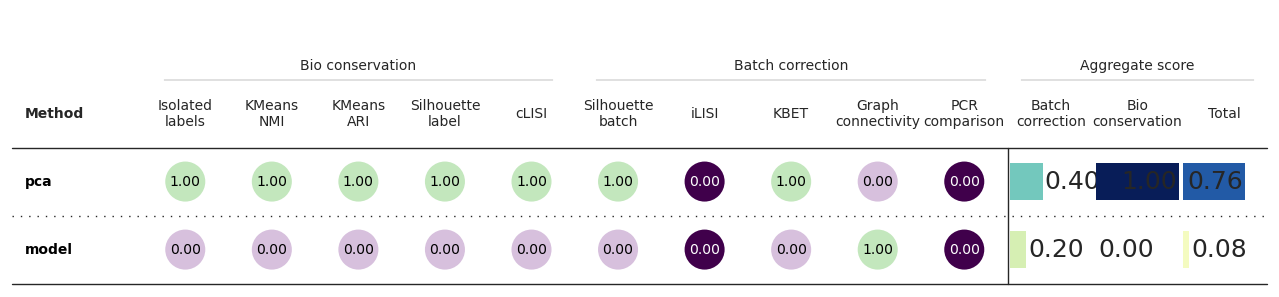

In [56]:
metrics.plot_scib_metrics()

### BATCH EFFECT MODEL

In [ ]:
model_cls = MultiModalSCVI
abundance_layer = 'norm_log1p'
spatial_layer='spatial_id'
max_epochs=10000

latent_name=f'weighted_latent'
    
setup_kwargs = dict(layer=abundance_layer, extra_modality_keys=[spatial_layer], n_modalities=2, batch_key='condition', spatial_mask_key=None,  )
model_kwargs = dict(n_latent=30, n_hidden=128, n_layers=2, dropout_rate=0.1, 
                            distrs=[D.Normal, D.Normal], 
                            
                            loss_weights='auto',
                            joint_kl=False, unimodal_kl=True,
                            
                            decoder_kwargs=dict(decoder_param_eps=1e-2, decoder_activation='exp')
                        )
train_kwargs = dict(train_size=0.8, check_val_every_n_epoch=1, early_stopping=True, 
                        early_stopping_patience=200, batch_size=2000,
                        max_epochs=max_epochs, enable_checkpointing=True, 
                        plan_kwargs=dict(lr=1e-4, optimizer='Adam', n_epochs_kl_warmup=400)
                    )
model = train_model(adata, model_cls=model_cls, setup_kwargs=setup_kwargs, model_kwargs=model_kwargs, train_kwargs=train_kwargs,)

/tmp/ipykernel_4008336/2480688354.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


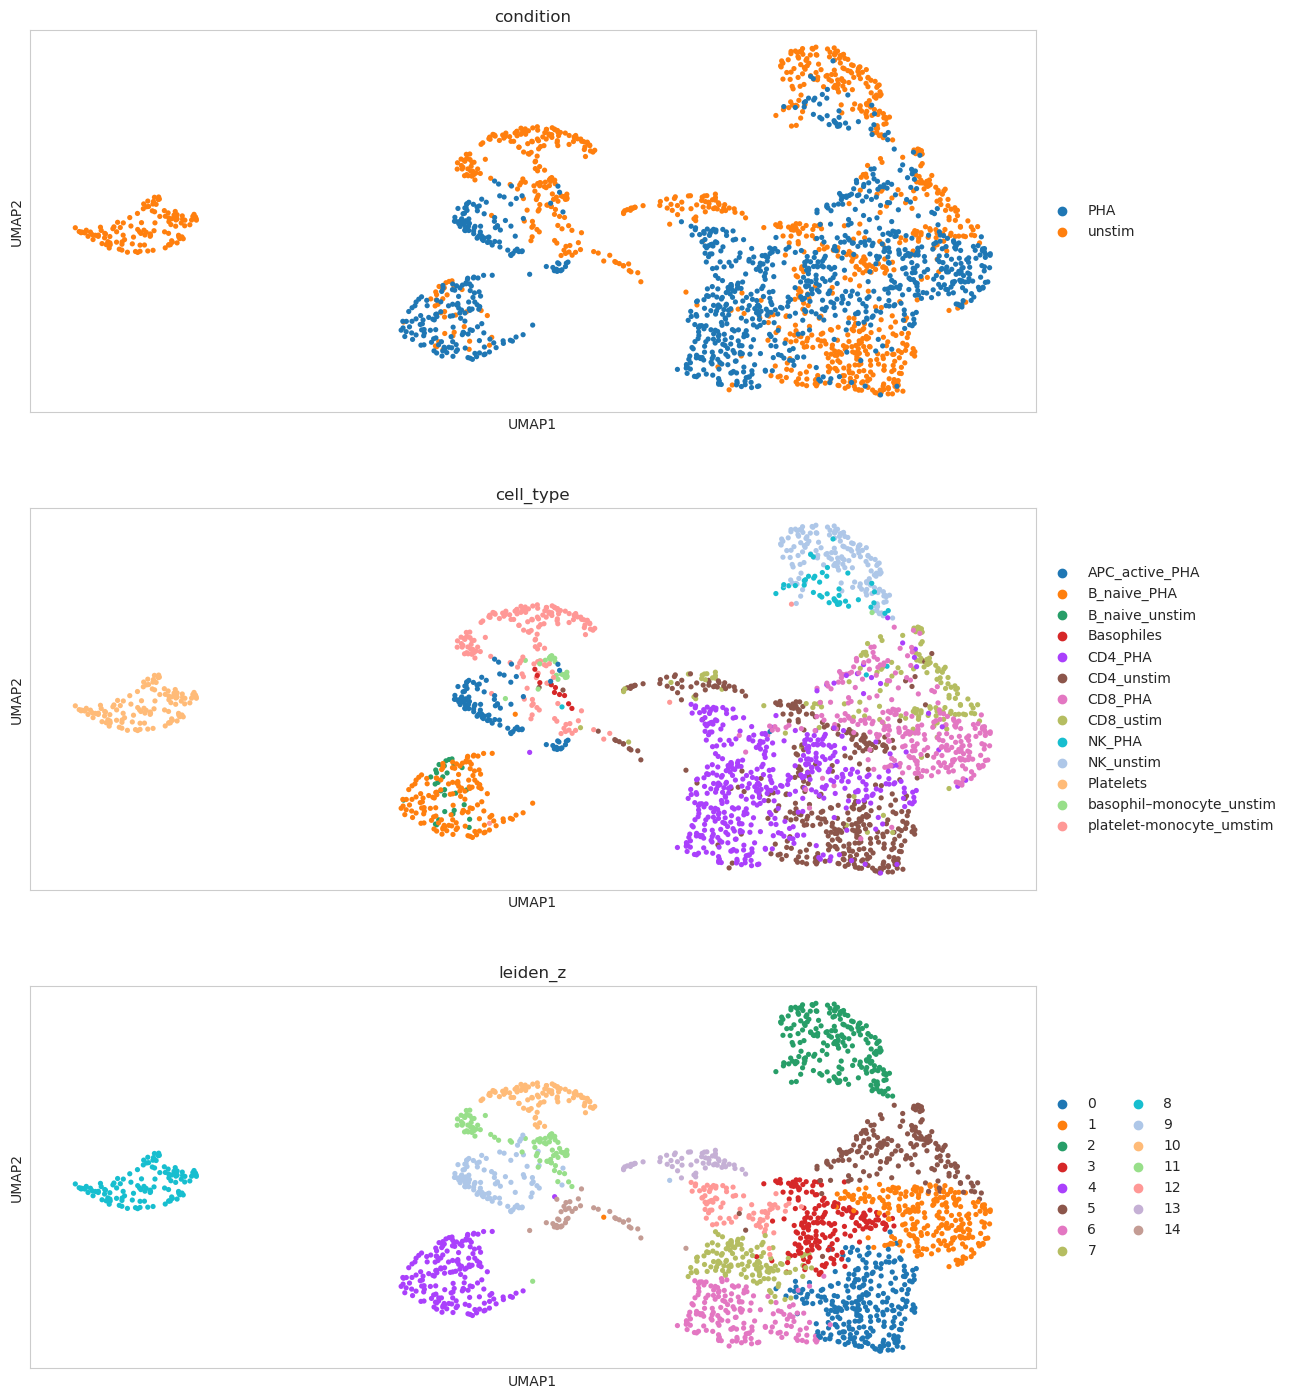

In [6]:
z=model.get_latent_representation(adata,)

adata.obsm['z']=z

sc.pp.neighbors(adata, n_neighbors=15, use_rep="z")
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.8, random_state=0, key_added='leiden_z')
sc.pl.umap(
    adata,
    color=['condition','cell_type','leiden_z'],
    ncols=1,
    show=False,
    
)
plt.gcf().set_size_inches(14, 16)

plt.tight_layout()
plt.show()

### SCVI MODEL

In [8]:
adata

AnnData object with n_obs × n_vars = 2132 × 158
    obs: 'n_umi1', 'n_umi2', 'n_edges', 'reads_in_component', 'n_antibodies', 'n_umi', 'isotype_fraction', 'intracellular_fraction', 'tau_type', 'tau', 'disqualified_for_denoising', 'number_of_nodes_removed_in_denoise', 'sample', 'antibodies', 'average_k_core', 'k_core_1', 'k_core_2', 'k_core_3', 'k_core_4', 'svd_var_expl_s1', 'svd_var_expl_s2', 'svd_var_expl_s3', 'condition', 'total_counts', 'leiden', 'cell_type', '_scvi_batch', '_scvi_labels', 'leiden_z'
    var: 'antibody_count', 'antibody_pct', 'components', 'control', 'nuclear', 'detection_rate', 'whitelisted', 'keep_protein'
    uns: 'cell_type_colors', 'condition_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap', '_scvi_uuid', '_scvi_manager_uuid', 'leiden_z', 'leiden_z_colors'
    obsm: 'X_pca', 'X_umap', 'clr', 'log1p', 'spatial_arcsinh', 'spatial_arcsinh_2000', 'spatial_id', 'pca', 'z'
    varm: 'PCs'
    layers: 'counts', 'log1p', 'norm_log1p'
    obsp: 'c

In [12]:
SCVI.setup_anndata(adata, layer='counts', batch_key="condition")
model = SCVI(adata, n_latent=30)
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [13]:
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

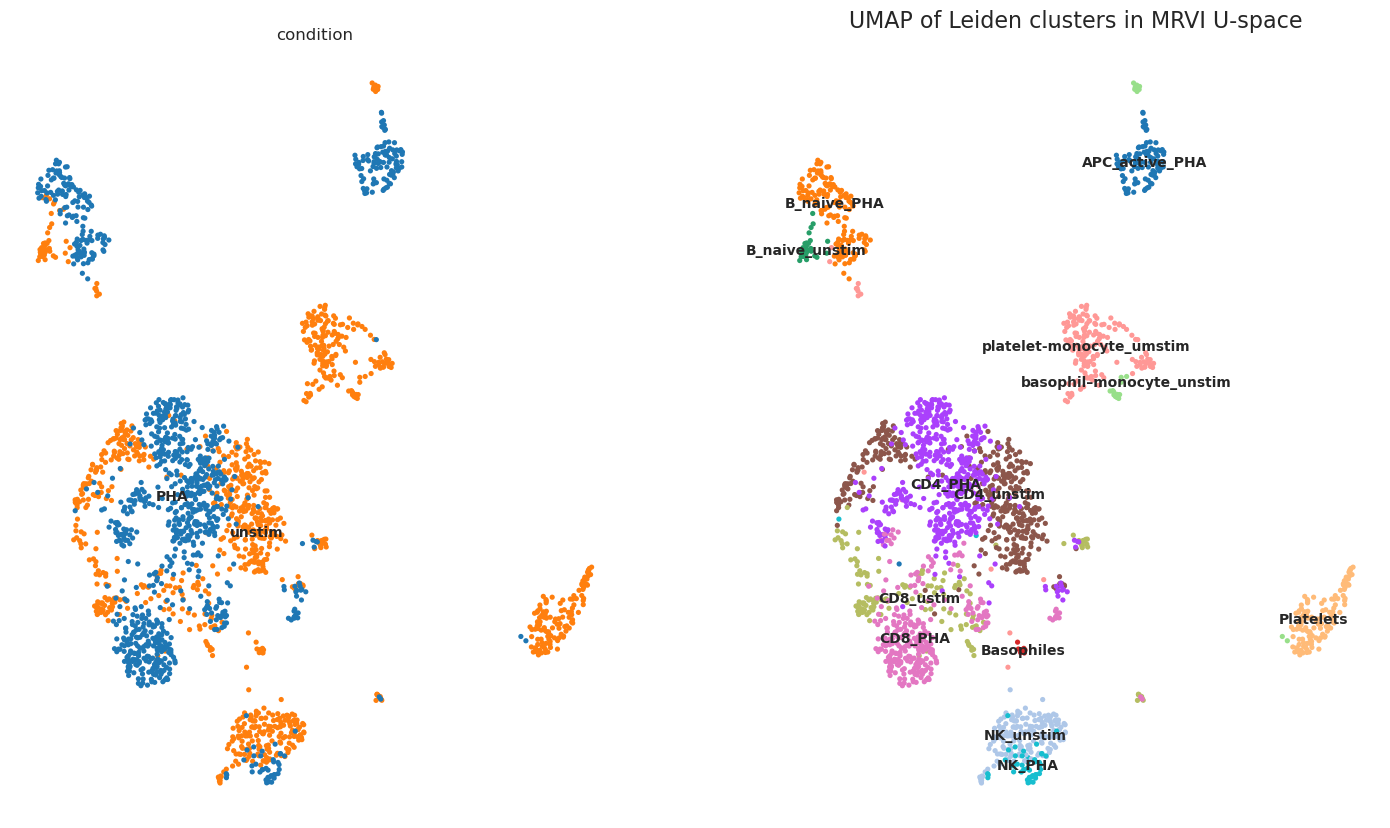

In [17]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["condition", "cell_type"], legend_loc='on data',frameon=False, show=False)
plt.gcf().set_size_inches(18, 10)
plt.title("UMAP of Leiden clusters in MRVI U-space", fontsize=16, pad=15)
plt.show()

# SPATIAL

In [58]:
adata.obs.cell_type.value_counts()

cell_type
CD4_PHA                     481
CD4_unstim                  398
CD8_PHA                     287
platelet-monocyte_umstim    170
NK_unstim                   166
CD8_ustim                   152
B_naive_PHA                 148
Platelets                   121
APC_active_PHA              100
NK_PHA                       44
B_naive_unstim               30
basophil–monocyte_unstim     25
Basophiles                   10
Name: count, dtype: int64

In [59]:
adata.obsm['spatial_id']

,B2M/B2M,B2M/CD102,B2M/CD103,B2M/CD117,B2M/CD11a,B2M/CD11b,B2M/CD11c,B2M/CD123,B2M/CD127,B2M/CD13,...,TCRVg9/TCRVg9,TCRVg9/TIGIT,TCRab/TCRab,TCRab/TCRva7.2,TCRab/TIGIT,TCRgd/TIGIT,TCRva7.2/TCRva7.2,TCRva7.2/TIGIT,TIGIT/TIGIT,VISTA/VISTA
component,,,,,,,,,,,,,,,,,,,,,
f1b52a4758932fc7,-2.778424,-1.935733,0.000000,0.000000,0.019950,0.000000,0.000000,0.000000,1.016140,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eca4983191f3647f,0.495860,1.527487,0.000000,0.000000,1.769517,0.000000,0.000000,0.000000,-1.474033,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f98240c66b2e49fc,3.320315,-0.105619,0.000000,0.000000,0.107288,0.000000,0.000000,0.000000,-0.122992,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b5f8b192a0cc2603,2.901583,-3.054177,0.000000,-0.602268,-1.160391,0.411088,-1.344538,0.000000,4.148370,-0.875879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7994e60e303c6dbb,-0.367317,-0.659875,0.000000,0.000000,0.464993,0.000000,0.000000,0.000000,-0.371784,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe9e06d663b632d1,1.457192,-1.225364,0.000000,0.000000,1.086769,0.000000,0.000000,0.000000,0.608254,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b526da61c6941223,3.333858,0.854115,0.000000,0.000000,2.985231,0.000000,0.000000,0.000000,1.156773,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8c26b116f942b613,1.803737,-0.120755,1.470225,0.000000,0.658601,0.000000,0.000000,0.000000,-2.129343,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
cell_types

component
f1b52a4758932fc7                  CD4_unstim
eca4983191f3647f                  CD4_unstim
f98240c66b2e49fc                   CD8_ustim
b5f8b192a0cc2603    platelet-monocyte_umstim
7994e60e303c6dbb                   CD8_ustim
                              ...           
fe9e06d663b632d1                     CD8_PHA
b526da61c6941223                     CD4_PHA
8c26b116f942b613                     CD8_PHA
9567c4b0b99c07ab                     CD8_PHA
1a14cfd48348799d              APC_active_PHA
Name: cell_type, Length: 2132, dtype: category
Categories (13, object): ['APC_active_PHA', 'B_naive_PHA', 'B_naive_unstim', 'Basophiles', ..., 'NK_unstim', 'Platelets', 'basophil–monocyte_unstim', 'platelet-monocyte_umstim']

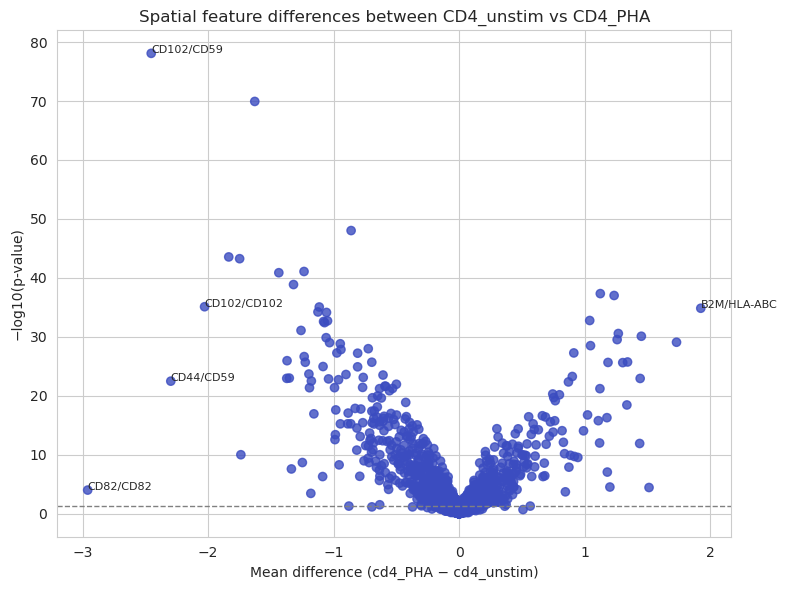

,feature,mean_diff,pval,padj,log10p,abs_diff
7208,CD82/CD82,-2.959250,1.031385e-04,NaN,3.986579,2.959250
260,CD102/CD59,-2.453152,8.086438e-79,NaN,78.092243,2.453152
6038,CD44/CD59,-2.297143,3.386171e-23,NaN,22.470291,2.297143
155,CD102/CD102,-2.027979,8.032005e-36,NaN,35.095176,2.027979
134,B2M/HLA-ABC,1.924918,1.443712e-35,NaN,34.840520,1.924918
4039,CD27/CD44,-1.835523,2.834009e-44,NaN,43.547599,1.835523
242,CD102/CD44,-1.748745,5.653176e-44,NaN,43.247707,1.748745
6622,CD52/CD59,-1.738947,1.038839e-10,NaN,9.983452,1.738947
7388,HLA-ABC/HLA-ABC,1.731658,8.469873e-30,NaN,29.072123,1.731658
3800,CD25/CD44,-1.628319,1.173190e-70,NaN,69.930632,1.628319


In [ ]:
spatial_df = pd.DataFrame(adata.obsm["spatial_id"], index=adata.obs_names)
cell_types = adata.obs["cell_type"]

group1 = spatial_df[cell_types == "CD4_unstim"]
group2 = spatial_df[cell_types == "CD4_PHA"]

results = []
for col in spatial_df.columns:
    vals1 = group1[col].dropna()
    vals2 = group2[col].dropna()
    if len(vals1) > 2 and len(vals2) > 2:  # avoid empty groups
        stat, pval = stats.ttest_ind(vals1, vals2, equal_var=False)
        diff = np.mean(vals2) - np.mean(vals1)
        results.append((col, diff, pval))

results_df = pd.DataFrame(results, columns=["feature", "mean_diff", "pval"])
results_df["padj"] = multipletests(results_df["pval"], method="fdr_bh")[1]
results_df["log10p"] = -np.log10(results_df["pval"])
results_df["abs_diff"] = results_df["mean_diff"].abs()

plt.figure(figsize=(8,6))
plt.scatter(results_df["mean_diff"], results_df["log10p"],
            c=(results_df["padj"] < 0.05), cmap="coolwarm", alpha=0.8)
plt.axhline(-np.log10(0.05), color="grey", ls="--", lw=1)
plt.xlabel("Mean difference (cd4_PHA − cd4_unstim)")
plt.ylabel("−log10(p-value)")
plt.title("Spatial feature differences between CD4_unstim vs CD4_PHA")

top_features = results_df.sort_values("abs_diff", ascending=False).head(5)
for _, row in top_features.iterrows():
    plt.text(row["mean_diff"], row["log10p"], row["feature"], fontsize=8)

plt.tight_layout()
plt.show()



In [65]:
results_df.sort_values(["pval", "abs_diff"], ascending=[True, False]).head(10)


,feature,mean_diff,pval,padj,log10p,abs_diff
260,CD102/CD59,-2.453152,8.086438e-79,NaN,78.092243,2.453152
3800,CD25/CD44,-1.628319,1.173190e-70,NaN,69.930632,1.628319
2995,CD2/CD25,-0.860726,9.496935e-49,NaN,48.022417,0.860726
4039,CD27/CD44,-1.835523,2.834009e-44,NaN,43.547599,1.835523
242,CD102/CD44,-1.748745,5.653176e-44,NaN,43.247707,1.748745
922,CD127/CD43,-1.235677,8.370847e-42,NaN,41.077231,1.235677
3030,CD2/CD43,-1.436543,1.354684e-41,NaN,40.868162,1.436543
6371,CD48/CD48,-1.319531,1.374756e-39,NaN,38.861774,1.319531
6576,CD50/CD6,1.124554,4.750008e-38,NaN,37.323306,1.124554
5787,CD4/CD45,1.234555,9.906064e-38,NaN,37.004099,1.234555


In [ ]:
# look at abundance
# take top 10 for activated\unactuvated
# size of dot should be abundance